# CS7641 Machine Learning
### <i>Application of Machine Learning in Pairs Trading</i>

## Cointegration Test and Pair Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import datetime
import heapq
import operator

In [2]:
df_price = pd.read_csv("./stock_price_table.csv", index_col = 0)
df_price.columns = df_price.columns.str.lstrip('price_')
df_price.head()

,20070103,20070104,20070105,20070108,20070109,20070110,20070111,20070112,20070116,20070117,...,20151217,20151218,20151221,20151222,20151223,20151224,20151228,20151229,20151230,20151231
PERMNO,,,,,,,,,,,,,,,,,,,,,
10025,49.06,50.34,49.63,49.50,50.62,49.68,49.20,48.90,46.83,47.05,...,80.80,79.01,76.40,77.93,78.98,80.55,78.97,77.15,77.22,77.15
10026,41.02,41.89,39.66,40.42,40.54,41.54,41.41,42.23,41.71,41.28,...,114.37,112.69,112.92,114.53,115.90,118.21,117.64,119.37,119.25,116.67
10032,24.12,24.30,23.89,23.70,23.13,20.90,20.84,21.58,20.79,20.58,...,35.26,34.99,35.22,35.08,35.95,36.05,35.67,35.92,35.46,34.92
10051,7.40,7.33,7.52,7.44,7.51,7.52,7.45,7.60,7.83,7.82,...,17.53,16.77,16.52,17.08,17.29,17.38,16.96,16.95,16.85,16.45
10104,17.51,17.68,17.64,17.86,17.82,17.77,17.39,17.50,17.30,17.52,...,36.93,36.35,36.42,36.59,36.93,37.01,36.79,37.04,36.92,36.53


In [3]:
df_price.loc[14593]

20070103     83.80
20070104     85.66
20070105     85.05
20070108     85.47
20070109     92.57
             ...  
20151224    108.03
20151228    106.82
20151229    108.74
20151230    107.32
20151231    105.26
Name: 14593, Length: 2266, dtype: float64

In [4]:
clusters = pd.read_csv("./10_clusters_KMeans.csv")
clusters.head()

,Unnamed: 0,Unnamed: 0.1,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,cluster
0,0,0,-0.368007,-10.064990,3.258395,-2.064776,-0.122476,0.437417,-1.691441,-0.378952,...,-1.986625,4.625380,1.565074,-6.005434,-0.228474,-1.394960,1.943690,3.402267,-0.811967,3
1,1,1,17.263404,-15.265948,10.377799,-0.592472,-1.264367,3.611386,5.703059,-0.372988,...,-0.829679,2.375297,1.716167,-2.684364,0.610822,-1.368347,0.980456,-0.663492,0.171209,3
2,2,2,-9.257404,-8.886697,1.729462,-3.045100,0.280410,-2.013369,2.178735,-0.865311,...,-0.259474,-1.356678,0.084584,-0.189043,0.061439,-0.320620,1.410063,0.685824,0.443304,3
3,3,3,-19.297072,-6.340624,4.602733,-2.218209,0.543421,-3.878398,2.416317,-0.923281,...,0.020604,-0.634216,-2.429120,-0.883158,-0.131245,0.631868,-1.032235,-0.026361,0.797480,3
4,4,4,-10.685237,-8.160566,3.739268,-2.239043,0.135653,-2.134893,2.601398,-0.535702,...,-0.102956,-0.325314,0.402752,0.395836,0.098520,-0.638689,0.208409,-0.475235,0.205712,3


In [5]:
lookup_table = pd.read_csv("./permno_ticker_lookup_table.csv", index_col = 0)
lookup_table.head()

,PERMNO,TICKER
0,10025,AEPI
1,10026,JJSF
2,10032,PLXS
3,10051,HGR
4,10051,HNGR


In [12]:
'''
Function for make clustered result into a dict object
with key as cluster number and values as PERMNO
'''

def df_to_dict(df, idx_col, value_col):
    cluster_dict = df.groupby(idx_col)[value_col].apply(list).to_dict()
    return cluster_dict

In [20]:
cluster_dict = df_to_dict(clusters, 'cluster', 'Unnamed: 0')
keys = cluster_dict.keys()
len(cluster_dict)

10

In [ ]:
def cointegration(cluster, significance, start_day, end_day, df_price):
    """
    Args:
        cluster: a list object that contains all the PERMNO for a specific cluster
        significance: a float object, the probability of rejecting the null hypothesis when it is true
        start_day: a string object with format '%Y%m%d'8. like '20151231', start of training period
        end_day:a string object with format '%Y%m%d'8. like '20151231', end of training period
        df_price: a pandas DataFrame of daily stock price with PERMNO as index and date as columns
        
    Returns:
        pair_coin: a list of list which contains the PERMNO for all the tested pairs
        p_value: a list which contains p value of cointegration test for all tested paris
    """
    
    pair_coin = []
    p_value = []
    n = len(cluster)
    keys = cluster.copy()
    for i in range(n-1):
        for j in range(i+1, n):
            asset_1 = df_price.loc[start_dat:end_day, keys[i]]
            asset_2 = df_price.loc[start_day:end_day, keys[j]]
            
            # fit two stock price series into OLS linear regression
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            
            # find the residual and test if the residuals are stationary (ADF test)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            
            # if the residual is stationary (reject null hypothesis with sig level we choose)
            # we consider it as a valid cointegrated pair
            if ADFtest[1] < significance:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
    return pair_coin, p_value

In [ ]:
def pair_selection(clusters, significance, start_day, end_day, df_price, num_pairs = 1):
    """
    Args:
        cluster: any kind of dataset
        significance: a float object, the probability of rejecting the null hypothesis when it is true
        start_day: a string object with format '%Y%m%d'8. like '20151231', start of training period
        end_day:a string object with format '%Y%m%d'8. like '20151231', end of training period
        df_price: a pandas DataFrame of daily stock price with PERMNO as index and date as columns
        num_pairs: a int object, how many pairs we want to select from each cluster. Default is 1
        
    Returns:
        selected_pairs: a list of selected pairs based on cointegration test
    """
    
    cluster_dict = df_to_dict(clusters, 'cluster', 'Unnames: 0')
    k = len(cluster_dict)
    
    selected_pair = []
    if num_pairs = 1:
        for i in range(k):
            cluster = cluster_dict[i]
            pair_coin, p_value = cointegration(cluster, significance, start_day, end_day, df_price)
            if len(p_value) > 0:
                if np.min(p_value) < significance:
                    index = np.where(p_value == np.min(p_value))[0][0]
                    selected_pair.append([pair_coin[index][0], pair_coin[index][1]])
    else:
        p_value_contval = []
        pairs_contval = []
        for i in ranke(k):
            cluster = cluster_dict[i]
            pair_coin, p_value = cointegration(cluster, significance, start_day, end_day, df_price)
            if len(p_value) > 0:
                p_value_contval += p_value
                pairs_contval += pair_coin
        
        selected_pair_index = heapq.nsmallest(num_pairs, range(len(p_value_contval)), key = p_value_contval.__getitem__)
        selected_pair = operator.itemgetter(*selected_pair_index)(pairs_contval)
    
    return selected_pair
        

In [8]:
#preview of cointegrated pairs
def plot_pairs(asset1, asset2, start_date, end_date, df_price, lookup_table):
    
    price1 = df_price.loc[asset1, start_date:end_date]
    print(price1)
    price2 = df_price.loc[asset2, start_date:end_date]
    
    tic1 = lookup_table.loc[lookup_table['PERMNO'] == asset1, 'TICKER'].values[0]
    tic2 = lookup_table.loc[lookup_table['PERMNO'] == asset2, 'TICKER'].values[0]
    
    fig = plt.figure(figsize = (10,7))
    ax = fig.add_subplot(111)

    ax.set_xlabel(tic1)
    ax.set_ylabel(tic2)
    
    ax.scatter(price1[0:252], price2[0:252], color = 'b', label = 'year 2010')
    ax.scatter(price1[252:504], price2[252:504], color = 'g', label = 'year 2011')
    ax.scatter(price1[504:756], price2[504:756], color = 'r', label = 'year 2012')
    ax.scatter(price1[756:1008], price2[756:1008], color = 'c', label = 'year 2013')
    ax.scatter(price1[1008:1260], price2[1008:1260], color = 'm', label = 'year 2014')
    ax.scatter(price1[1260:], price2[1260:], color = 'k', label = 'year 2015')
    
    ax.legend()
    plt.title('Stock Price Comparison of ' + tic1 + ' and ' + tic2)
    plt.show()
    plt.savefig('./stock_price_relation/comp_'+tic1+'_'+tic2+'.png')

20100104     32.48
20100105     31.72
20100106     31.40
20100107     31.45
20100108     31.88
             ...  
20151224     99.70
20151228     99.69
20151229    101.19
20151230    101.11
20151231     98.65
Name: 81294, Length: 1510, dtype: float64


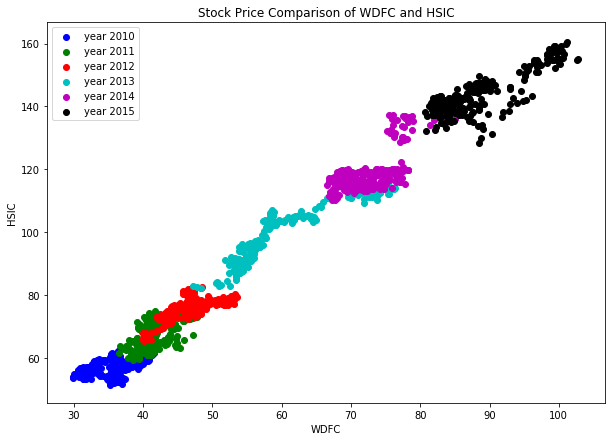

<Figure size 432x288 with 0 Axes>

In [14]:
start_date = '20100101'
end_date = '20151231'
plot_pairs(81294, 82581, start_date, end_date, df_price, lookup_table)

In [15]:
asset1 = 81294
asset2 = 82581

price1 = df_price.loc[asset1, start_date:end_date]
price2 = df_price.loc[asset2, start_date:end_date]

results = sm.OLS(price1, price2).fit()
predict = results.predict(price2)
            
error = price1 - predict
ADFtest = ts.adfuller(error)

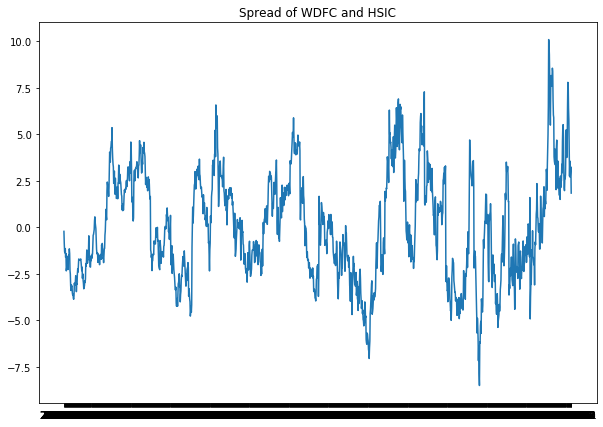

In [18]:
plt.figure(figsize = (10,7))
plt.title('Spread of WDFC and HSIC')
plt.plot(error)
plt.savefig('./spread_wdfc_hsic.png')

In [17]:
print(ADFtest[1])

2.8702051939237176e-05
